In [1]:
from Fotomics import LogScaler,FftTransformer

/home/aj/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:

import pandas as pd
import numpy as np
import scanpy as sc

from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect
from numpy.fft import fft, fftshift
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import seaborn as sns

In [3]:

expr_file = "data/Smartseq2_upperlim_gbm_data.h5ad"
adata = sc.read_h5ad(expr_file)
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
y = adata.obs["tumour name"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

np.unique(y, return_counts=True)


(array(['BT1160', 'BT1187', 'BT749', 'BT771', 'BT786', 'BT830', 'BT920',
        'MGH100', 'MGH101', 'MGH102', 'MGH104', 'MGH105', 'MGH106',
        'MGH110', 'MGH113', 'MGH115', 'MGH121', 'MGH122', 'MGH124',
        'MGH125', 'MGH128', 'MGH129', 'MGH136', 'MGH143', 'MGH151',
        'MGH152', 'MGH66', 'MGH85'], dtype=object),
 array([260, 200, 221, 186, 124, 167, 296, 136, 166, 262, 260, 505, 156,
        272, 229,  94, 254, 165, 251, 313,  65, 144, 180, 248, 136, 117,
        358, 170]))

In [4]:
def shuffle_data(x):
    
    # save header
    tmp_head = x[0]

    #remove header 
    x = x[1:]

    # shuffle by row 
    np.random.shuffle(x)

    #stack header
    x = np.vstack((tmp_head,x))

    # shuffle by column after T transformation 
    x = x.T 

    tmp_head = x[0]
    x = x[1:]

    np.random.shuffle(x)

    x = np.vstack((tmp_head,x))

    return x

In [5]:
# Step 1: Combine X and y into a DataFrame (no shuffle yet)
df = pd.DataFrame(X, columns=adata.var_names)
df["label"] = y.astype(str)  # preserve label strings

# Step 2: Remove rare classes
df = df[df["label"].map(df["label"].value_counts()) >= 2]

# Step 3: Extract features and labels
mt_X = df.drop("label", axis=1).values
mt_Y = df["label"].values

# Step 4: Shuffle only the rows (not columns!)
from sklearn.utils import shuffle
mt_X, mt_Y = shuffle(mt_X, mt_Y, random_state=42)

# Step 5: Train/test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    mt_X, mt_Y, test_size=0.2, stratify=mt_Y, random_state=42)


In [6]:
ln = LogScaler()

x_train_norm = ln.fit_transform(x_train)
x_test_norm = ln.transform(x_test)

/home/aj/Desktop/ComareModels/Fotomics/Fotomics.py:134: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


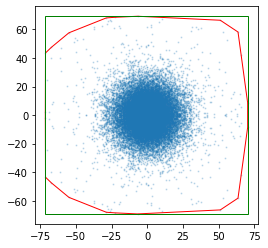

In [7]:
it = FftTransformer(pixels=124)
_ = it.fit(x_train_norm, plot=True)

In [8]:
x_train_img = it.transform(x_train_norm)
x_train_img.shape

(4748, 124, 124, 3)

In [9]:
x_test_img = it.transform(x_test_norm)
x_test_img.shape

(1187, 124, 124, 3)

Train img


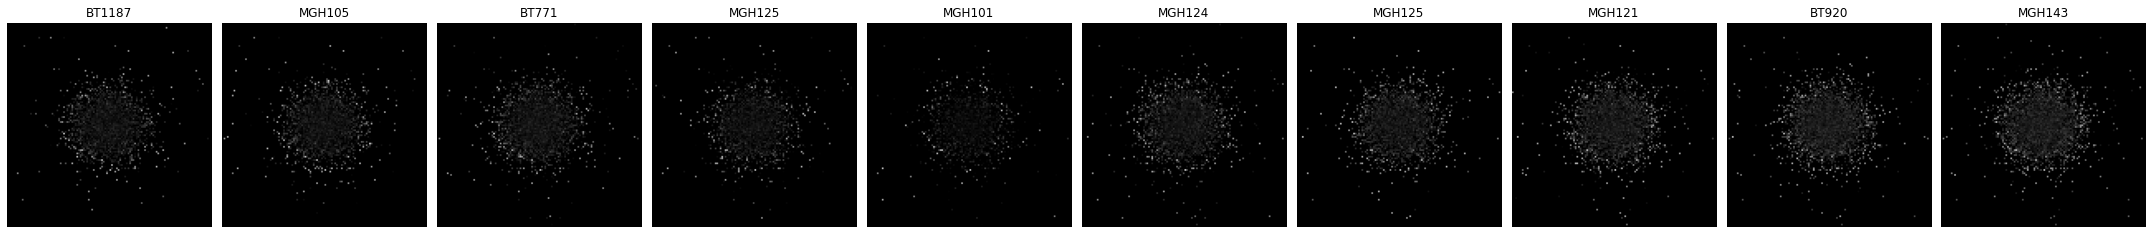

In [10]:
import matplotlib.pyplot as plt

print("Train img")

# Plot 10 images with tumor name titles
fig, axarr = plt.subplots(1, 10, figsize=(30, 4))

for i in range(10):
    axarr[i].imshow(x_train_img[i])
    axarr[i].set_title(str(y_train[i]), fontsize=12)
    axarr[i].axis('off')

plt.tight_layout()
plt.show()



Test img


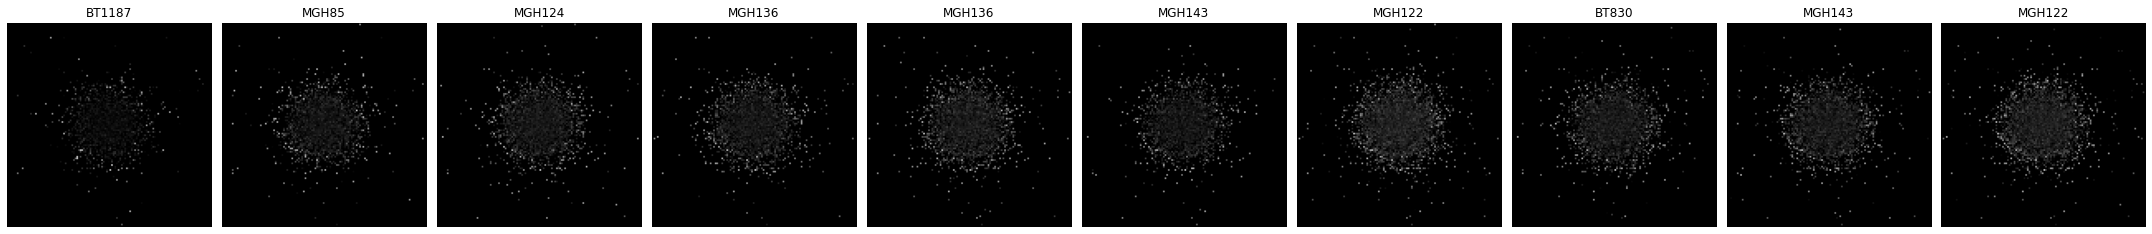

In [11]:
print("Test img")
f, axarr = plt.subplots(1, 10, figsize=(30, 4))

for i in range(10):   
    axarr[i].imshow(x_test_img[i])
    axarr[i].set_title(y_test[i])
    axarr[i].axis('off')

plt.tight_layout()
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np


In [13]:
unique_classes = np.unique(np.concatenate([y_train, y_test]))
label = unique_classes.tolist()
label_to_index = {lbl: idx for idx, lbl in enumerate(label)}

y_new_train = np.array([label_to_index[y] for y in y_train], dtype='float64')
y_new_test = np.array([label_to_index[y] for y in y_test], dtype='float64')



In [14]:
df_y_train = torch.tensor(y_new_train, dtype=torch.long)  # no one-hot needed



In [15]:
print(x_train_img.shape)   # → (num_train_samples, 124, 124, 3)
print(df_y_train.shape)    # → (num_train_samples, num_classes)


(4748, 124, 124, 3)
torch.Size([4748])


In [16]:


class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 29 * 29, 64)  # Adjusted to match image size
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # No softmax needed with CrossEntropyLoss


In [17]:
X_train_tensor = torch.tensor(x_train_img.transpose(0, 3, 1, 2), dtype=torch.float32)
y_train_tensor = torch.tensor(y_new_train, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Validation split (80/20)
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=len(label)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=8, factor=0.1)

best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(90):
    model.train()
    total_loss, correct = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == y_batch).sum().item()

    train_acc = correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Scheduler and Early Stopping
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # ModelCheckpoint
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1: Train Acc=0.0900, Val Loss=3.0681, Val Acc=0.1697
Epoch 2: Train Acc=0.3435, Val Loss=1.7979, Val Acc=0.5026
Epoch 3: Train Acc=0.6086, Val Loss=1.3618, Val Acc=0.6122
Epoch 4: Train Acc=0.7031, Val Loss=1.2112, Val Acc=0.6533
Epoch 5: Train Acc=0.7760, Val Loss=1.1515, Val Acc=0.6660
Epoch 6: Train Acc=0.7999, Val Loss=1.0654, Val Acc=0.6891
Epoch 7: Train Acc=0.8355, Val Loss=1.1327, Val Acc=0.6723
Epoch 8: Train Acc=0.8608, Val Loss=1.1459, Val Acc=0.6744
Epoch 9: Train Acc=0.8792, Val Loss=1.3214, Val Acc=0.6512
Epoch 10: Train Acc=0.9044, Val Loss=1.2291, Val Acc=0.6754
Epoch 11: Train Acc=0.9105, Val Loss=1.3895, Val Acc=0.6754
Epoch 12: Train Acc=0.9324, Val Loss=1.3747, Val Acc=0.6807
Epoch 13: Train Acc=0.9363, Val Loss=1.4173, Val Acc=0.6807
Epoch 14: Train Acc=0.9545, Val Loss=1.5013, Val Acc=0.6776
Epoch 15: Train Acc=0.9663, Val Loss=1.5925, Val Acc=0.6786
Epoch 16: Train Acc=0.9942, Val Loss=1.5210, Val Acc=0.6944
Early stopping triggered.


In [19]:
X_test_tensor = torch.tensor(x_test_img.transpose(0, 3, 1, 2), dtype=torch.float32)
y_test_tensor = torch.tensor(y_new_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)


In [20]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt


In [21]:
model.eval()
all_preds = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)

y_pred = np.array(all_preds)
y_true = y_new_test  # from earlier


In [25]:
from torch.utils.data import DataLoader, TensorDataset

# Build loader with batch inference to avoid OOM
train_dataset_eval = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_eval = DataLoader(train_dataset_eval, batch_size=32)

model.eval()
train_preds = []

with torch.no_grad():
    for X_batch, _ in train_loader_eval:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        train_preds.extend(preds)

train_accuracy = accuracy_score(y_new_train, train_preds)


In [27]:
#Get y_score (logits) from model in batches
y_score = []

model.eval()
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_score.append(outputs.cpu().numpy())

y_score = np.vstack(y_score)  # shape: (n_samples, n_classes)


In [28]:
from sklearn.preprocessing import label_binarize

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=np.arange(len(label)))

# Now compute ROC-AUC
roc_auc_macro = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovo')
roc_auc_weighted = roc_auc_score(y_true_bin, y_score, average='weighted', multi_class='ovo')


Training Accuracy: 0.9374473462510531
Test Accuracy: 0.7160909856781803
Precision (Macro): 0.7200935643486263
Precision (Micro): 0.7160909856781803
Precision (Weighted): 0.7213157413284179
Recall (Macro): 0.6973650321818818
Recall (Micro): 0.7160909856781803
Recall (Weighted): 0.7160909856781803
F1-score (Macro): 0.7036542074093538
F1-score (Micro): 0.7160909856781803
F1-score (Weighted): 0.7156815784426529
ROC-AUC (OvO, Macro): 0.9525143159060558
ROC-AUC (OvO, Weighted): 0.9523579435301393

Classification Report:
               precision    recall  f1-score   support

      BT1160       0.80      0.87      0.83        52
      BT1187       0.62      0.78      0.69        40
       BT749       0.88      0.95      0.91        44
       BT771       0.90      0.70      0.79        37
       BT786       0.88      0.88      0.88        25
       BT830       0.97      0.94      0.96        34
       BT920       0.88      0.90      0.89        59
      MGH100       0.71      0.56      0.62   

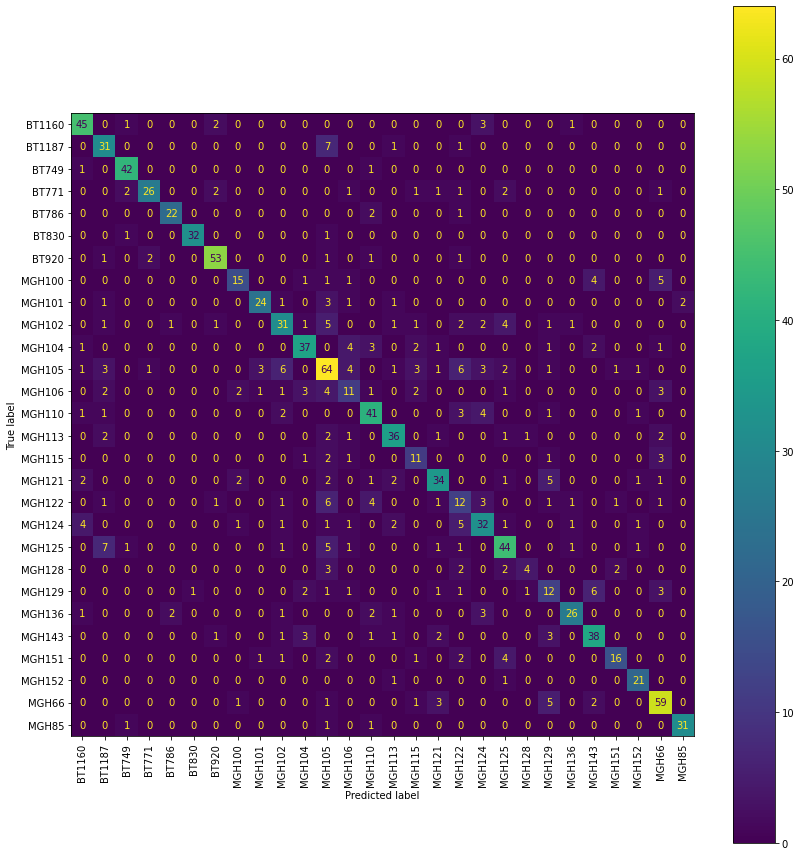

In [32]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=label)
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1-score (Macro):", f1_macro)
print("F1-score (Micro):", f1_micro)
print("F1-score (Weighted):", f1_weighted)
print("ROC-AUC (OvO, Macro):", roc_auc_macro)
print("ROC-AUC (OvO, Weighted):", roc_auc_weighted)
print("\nClassification Report:\n", report)

fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=label, ax=ax, xticks_rotation=90
)
plt.tight_layout()
plt.show()

